# Companion Notebook to `playing-with-coronavirus-data` 
- [GitHub Repo](https://github.com/jirvingphd/playing-with-coronavirus-data)
- James M. Irivng, Ph.D.
- james.irving.phd@gmail.com

# Business Problem

- Covid-19 and the various strains that have since emerged has upended modern life and fundamental changed how we function as a society.
- Part of what has made it difficult to tackle the pandemic is due to differences between states, state laws/policies, and a lack of public understanding about the predictability of the surges in cases. 


### Goal

- The goal of this notebook is to produce a workflow for producing forecasts of the following metrics at least 1 week ahead of time. 
    - Confirmed Cases
    - Number of Deaths
    - ICU Capacity
    
- The stretch goal for the project is to create a streamlit dashboard for getting state-level forecasts for any state in the US, using fresh daily data.
    

### Methodology

- To select 3-5 prototypical states representing very different time courses/
- Initial Thoughts:
    - NY
    - TX
    - FL
    - MD
    - LA

# Data

- See `Data Acquisition.py` and `Replacing Covid Tracking Project Data_08-2021.ipynb` for details (for now)


In [41]:
## Uncomment Cell to acquire new data
# !python data_acquisition.py

In [42]:
# !pip install fsds
# !pip install pmdarima

from fsds.imports import *
import os,glob,sys
import re

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

plt.rcParams['figure.figsize'] = (12,6)
pd.set_option('display.max_columns',0)

import statsmodels.tsa.api as tsa

In [43]:
%load_ext autoreload 
%autoreload 2
import coronavirus_functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


> Data is stored as both separate csvs for each state as well as one big dictionary in a joblib file.

#### CSV Data

In [44]:
import glob
query = "./data/combined_*.csv.gz"
# os.listdir('data/')
file_list = glob.glob(query)
file_list[:5]

['./data/combined_data_PR.csv.gz',
 './data/combined_data_FL.csv.gz',
 './data/combined_data_NV.csv.gz',
 './data/combined_data_MD.csv.gz',
 './data/combined_data_KS.csv.gz']

#### Joblib Data

In [45]:
import joblib
STATES = joblib.load('data/STATE_DICT.joblib')
STATES.keys()

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

In [46]:
STATES['FL']

,# Cases,# Deaths,inpatient_beds_utilization,inpatient_beds_utilization_coverage,inpatient_beds_utilization_numerator,inpatient_beds_utilization_denominator,adult_icu_bed_utilization,adult_icu_bed_utilization_coverage,adult_icu_bed_utilization_numerator,adult_icu_bed_utilization_denominator
date,,,,,,,,,,
2020-01-22,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-08-06,134751.0,616.0,0.839272,259.0,48546.0,57843.0,0.895147,259.0,5865.0,6552.0
2021-08-07,0.0,0.0,0.839904,257.0,48528.0,57778.0,0.895299,257.0,5866.0,6552.0
2021-08-08,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


# EDA

## Selecting Prototypical States

In [49]:
def get_state(STATES, state='NY',drop_cols=True,drop_exprs=['coverage','denominator' ]):
    df_state= STATES[state].copy()
    
    
    if drop_cols:
        cols_to_drop = []
        for expr in drop_exprs:
            cols_to_drop.extend([c for c in df_state.columns if expr.lower() in c.lower()])
        df_state = df_state.drop(columns=cols_to_drop)
        
    return df_state

### NY

In [50]:
ny = get_state(STATES,'NY')
ny

,# Cases,# Deaths,inpatient_beds_utilization,inpatient_beds_utilization_numerator,adult_icu_bed_utilization,adult_icu_bed_utilization_numerator
date,,,,,,
2020-01-22,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-23,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-24,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-25,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-26,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...
2021-08-06,3739.0,3.0,0.781316,39751.0,0.658052,3412.0
2021-08-07,4491.0,35.0,0.779076,39059.0,0.658556,3383.0
2021-08-08,3578.0,15.0,0.000000,0.0,0.000000,0.0


In [8]:
## make subplotsplot of time series # of cases vs utilization 
df_state = ny.copy()
drop_cols = [c for c in df_state.columns if ('numerator' in c)| ('denominator' in c)]
# df_state.drop(columns=drop_cols,inplace=True)
util_cols = [c for c in df_state.columns if c.endswith('utilization') ]
other_cols = [c for c in df_state.columns if c not in util_cols]
util_cols

['inpatient_beds_utilization', 'adult_icu_bed_utilization']

In [9]:
df_state

,# Cases,# Deaths,inpatient_beds_utilization,inpatient_beds_utilization_numerator,adult_icu_bed_utilization,adult_icu_bed_utilization_numerator
date,,,,,,
2020-01-22,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-23,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-24,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-25,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-26,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...
2021-08-06,3739.0,3.0,0.781316,39751.0,0.658052,3412.0
2021-08-07,4491.0,35.0,0.779076,39059.0,0.658556,3383.0
2021-08-08,3578.0,15.0,0.000000,0.0,0.000000,0.0


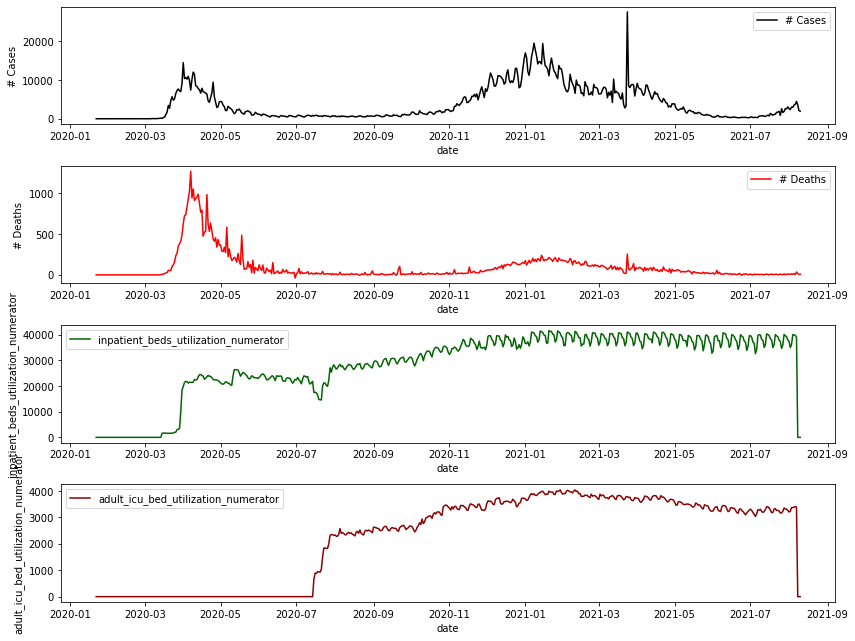

In [10]:
## 3 subplots
fig, axes = plt.subplots(nrows=4,figsize=(12,9))

# 1: cases
sns.lineplot(data = df_state,x=df_state.index,color='black', y='# Cases',
             ax=axes[0],label='# Cases')#.plot(ax=axes[0])
# 2: deaths
sns.lineplot(data = df_state,x=df_state.index,color='red',
             y='# Deaths',ax=axes[1],label='# Deaths')#.plot(ax=axes[0])

# 3: icu utilization
sns.lineplot(data=ny, x=df_state.index, y='inpatient_beds_utilization_numerator',
            ax=axes[2], color='darkgreen',label='inpatient_beds_utilization_numerator')

# 4: icu utilization
sns.lineplot(data=ny, x=df_state.index, y='adult_icu_bed_utilization_numerator',
            ax=axes[3], color='darkred',label='adult_icu_bed_utilization_numerator')
plt.tight_layout()

In [11]:
## Appending folder with functions
# %load_ext autoreload 
# %autoreload 2
# import sys
# sys.path.append('.')

# import functions as fn
# help(fn)

In [12]:
def plot_state(df_state, title='State Covid Statistics',figsize=(10,8)):
    drop_cols = [c for c in df_state.columns if ('numerator' in c)| ('denominator' in c)]
    df_state.drop(columns=drop_cols,inplace=True)
    util_cols = [c for c in df_state.columns if c.endswith('utilization') ]
    other_cols = [c for c in df_state.columns if c not in util_cols]

    ## 3 subplots
    fig, axes = plt.subplots(nrows=4,figsize=figsize)
    fig.suptitle(title)

    # 1: cases
    sns.lineplot(data = df_state,x=df_state.index,color='black', y='# Cases',
                 ax=axes[0],label='# Cases')#.plot(ax=axes[0])
    # 2: deaths
    sns.lineplot(data = df_state,x=df_state.index,color='red',
                 y='# Deaths',ax=axes[1],label='# Deaths')#.plot(ax=axes[0])

    # 3: icu utilization
    sns.lineplot(data=ny, x=df_state.index, y='inpatient_beds_utilization',
                ax=axes[2], color='darkgreen',label='inpatient_beds_utilization')

    # 4: icu utilization
    sns.lineplot(data=ny, x=df_state.index, y='adult_icu_bed_utilization',
                ax=axes[3], color='darkred',label='adult_icu_bed_utilization')
    plt.tight_layout()
    return fig

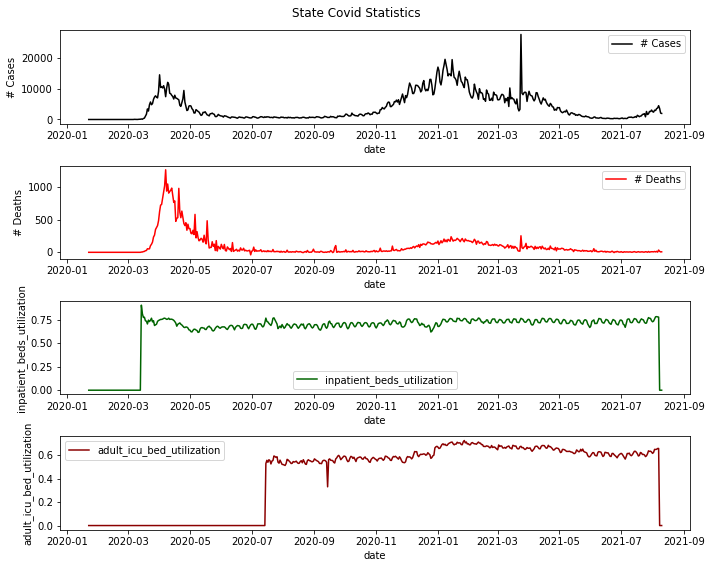

In [13]:
plot_state(ny);

# Time Series Modeling

## Functions

In [14]:
### FORECAST SPECIFIC FUNCTIONS
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sms
import statsmodels.tsa.api as tsa

# def get_forecast(model,steps=12):
#     pred = model.get_forecast(steps=steps)
#     forecast = pred.conf_int()
#     forecast.columns = ['Lower CI','Upper CI']
#     forecast['Forecast'] = pred.predicted_mean
#     return forecast

    
# def plot_forecast(model,ts,last_n_lags=52,future_steps=12):
#     forecast_df = get_forecast(model,steps=future_steps)

#     fig,ax = plt.subplots(figsize=(12,5))
#     ts.iloc[-last_n_lags:].plot(label='True Data')
#     forecast_df['Forecast'].plot(ax=ax)
#     ax.fill_between(forecast_df.index,
#                     forecast_df['Lower CI'], forecast_df['Upper CI'],alpha=0.6)
#     ax.legend()
#     ax.set(title=f'Forecasted {ts.name}')
#     return fig,ax


# def evaluate_model(model,ts,last_n_lags =52,steps=12):
#     display(model.summary())
#     model.plot_diagnostics();
#     fig,ax=plot_forecast(model,ts,future_steps=steps,last_n_lags=last_n_lags)
#     return fig,ax

In [15]:
from pmdarima import auto_arima

# def get_ts(df,col,fill_val=np.nan,**kwargs):
#     ts = df[col].fillna(value=fill_val)
#     return ts



# def get_best_model(ts,start_p=0,start_q=0,start_P=0,start_Q=0,m=7,
#                    as_sarimax = True, **kwargs):
    
#     auto_model = auto_arima(ts,start_p=start_p,
#                             start_q=start_q,start_P=start_P,start_Q=start_Q,m=m,)
#     print(f"[i] Best parameters found:")
#     display(auto_model.summary())

#     if as_sarimax:
#         model = SARIMAX(ts,order=auto_model.order, 
#                 seasonal_order =auto_model.seasonal_order,
#                 enforce_invertibility=False,freq='D').fit()
#         return model

#     else:
#         return auto_model

# # def get_forecast(model,steps=14):
# #     forecast = model.get_forecast(steps=steps)
# #     forecast_df = forecast.conf_int()
# #     forecast_df['Forecast'] = forecast.predicted_mean
# #     forecast_df.columns = ['lower','upper','Forecast']
# #     return forecast_df

    
# def plot_forecast(model,ts,last_n_days=60,future_steps=14):
#     forecast_df = get_forecast(model,steps=future_steps)

#     fig,ax = plt.subplots(figsize=(12,5))
#     ts.iloc[-last_n_days:].plot(label='True Data')
#     forecast_df['forecast'].plot(ax=ax)
#     ax.fill_between(forecast_df.index,
#                     forecast_df['lower'], forecast_df['upper'],alpha=0.6)
#     ax.legend()
#     ax.set(title=f'Forecasted {ts.name}')
#     return fig,ax

## NY

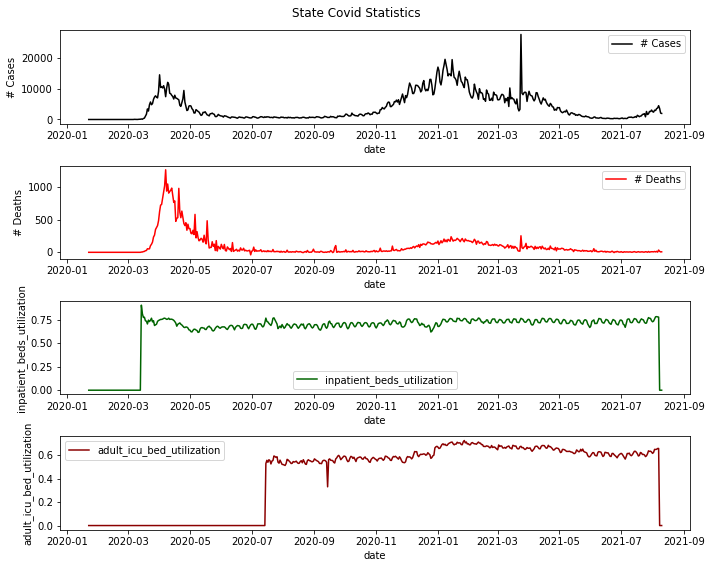

In [16]:
plot_state(ny);

### Checking Seasonal Decompose for Seasonality to Use

<AxesSubplot:xlabel='date'>

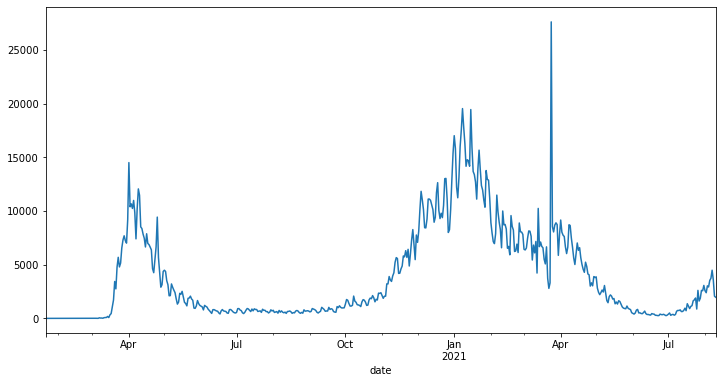

In [17]:
ts = ny['# Cases'].copy()
ts.plot()

### Number of Cases

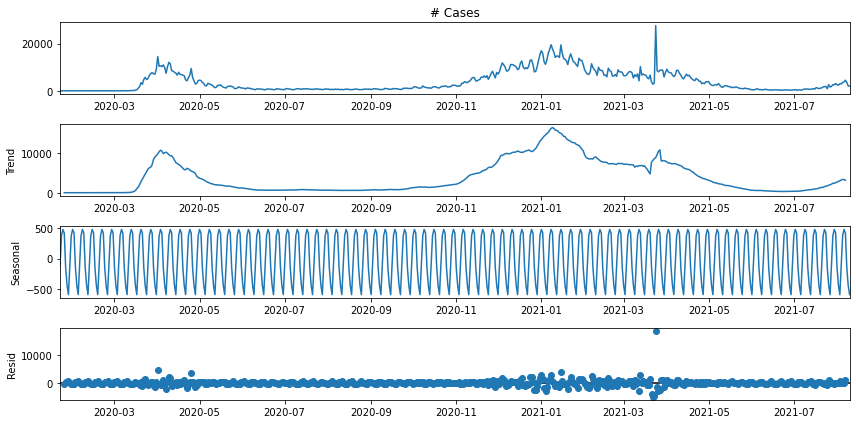

In [18]:
decomp = tsa.seasonal_decompose(ts)
decomp.plot();

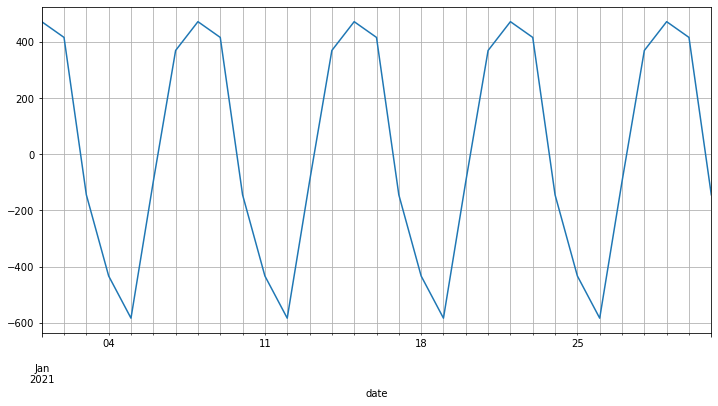

In [19]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-4.446855,14,545,0.000245,True,True


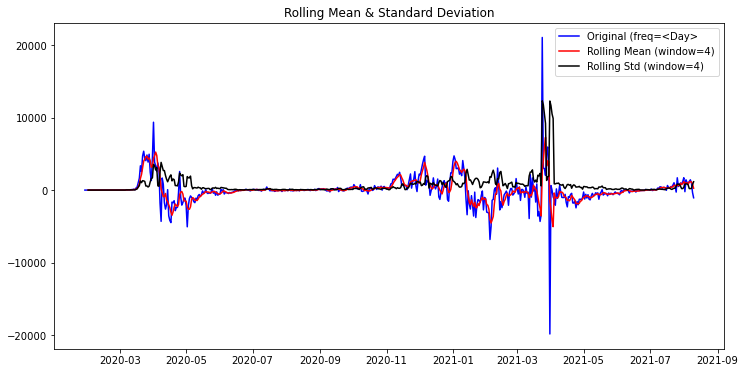

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-4.446855,14,545,0.000245,True,True


In [20]:
fn.stationarity_check(ts.diff(7).dropna(),window=4)

<AxesSubplot:xlabel='date'>

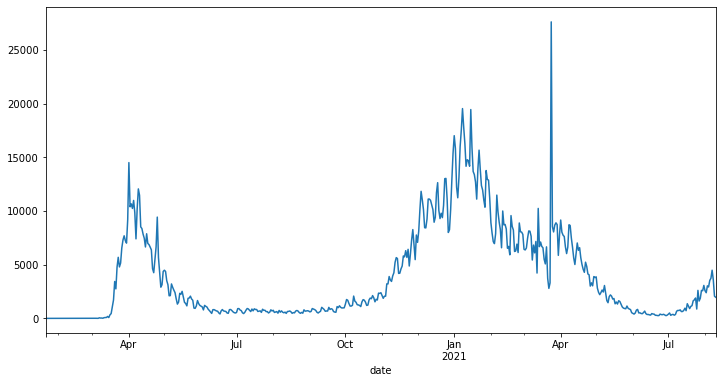

In [21]:
ts.plot()

In [22]:
ts.shape[0]-30

537

In [23]:
n=30

In [24]:
def train_test_split_ts(ts,test_size=0.9,split_index=None):
    """Uses test size by default, split_index overrides it"""
    if split_index is not None:
        tts_cutoff = split_index
    else:
        tts_cutoff = round(ts.shape[0]*0.9)
    fmt = "%m-%d-%Y"
    cutoff_time = ts.index[tts_cutoff]
    print(f"Using a cutoff index of {tts_cutoff}, which = {cutoff_time.strftime(fmt)}")
    
      ## Use the tts cutoff to do Train test split and plot
    train = ts.iloc[:tts_cutoff]
    test = ts.iloc[tts_cutoff:]

    ## Plot
    ax = train.plot(label='train')
    test.plot(label='test')
    ax.legend()
    ax.set(ylabel=ts.name)
    ax.axvline(cutoff_time,color='k',ls=':',label=cutoff_time.strftime(fmt))
    ax.legend()
    ax.set_title(f"Train Test Split for {ts.name}")
    return train, test


Using a cutoff index of -30, which = 07-12-2021


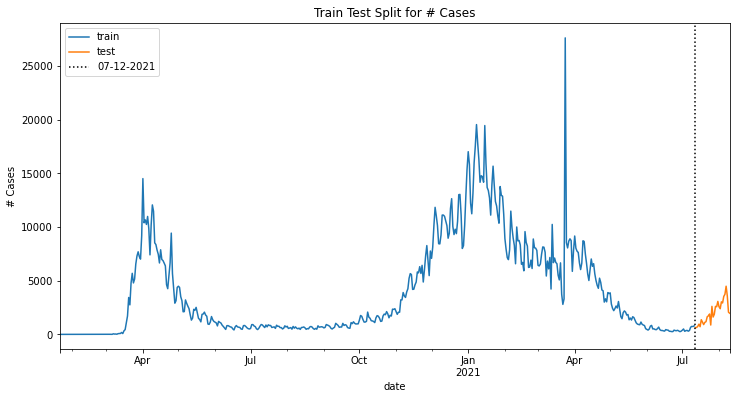

In [25]:
train,test = train_test_split_ts(ts,split_index=-30)

In [26]:
# ## train test spit
# # get the tts_cutoff  (the # of timesteps/rows to split at)
# tts_cutoff = round(ts.shape[0]*0.9)
# tts_cutoff

In [27]:
# ## Use the tts cutoff to do Train test split and plot
# train = ts.iloc[:tts_cutoff]
# test = ts.iloc[tts_cutoff:]

# ## Plot
# ax = train.plot(label='train')
# test.plot(label='test')
# ax.legend()

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-4.33684,14,515,0.000383,True,True


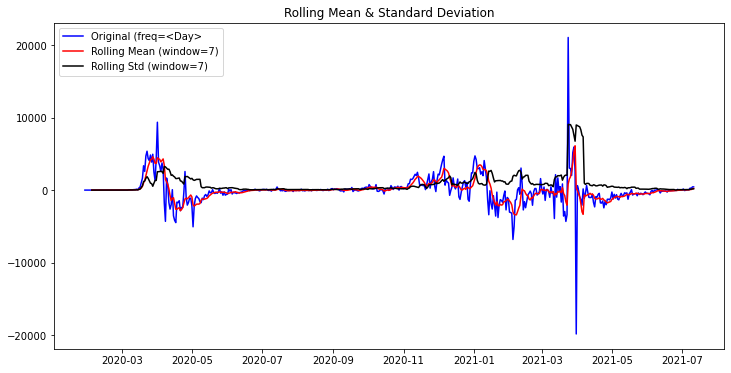

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-4.33684,14,515,0.000383,True,True


In [28]:
## check staationarity 
fn.stationarity_check(train.diff(7).dropna(), window=7)

[None, None]

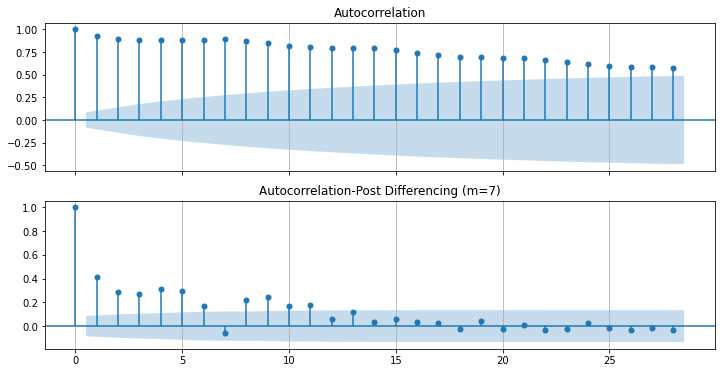

In [29]:
m=7
fig,axes = plt.subplots(nrows=2, sharex=True)
tsa.graphics.plot_acf(train,ax=axes[0],title='Autocorrelation')

tsa.graphics.plot_acf(train.diff(m).dropna(),ax=axes[1],title=f'Autocorrelation-Post Differencing (m={m})');
[a.grid(which='both',axis='x') for a in axes]

[None, None]

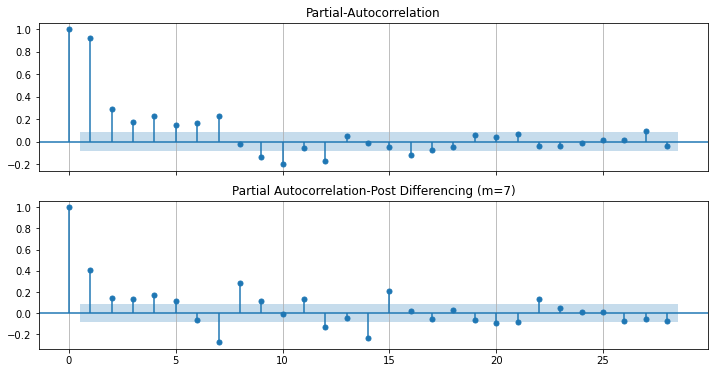

In [30]:
fig,axes = plt.subplots(nrows=2, sharex=True)
tsa.graphics.plot_pacf(train,ax=axes[0],title='Partial-Autocorrelation')

tsa.graphics.plot_pacf(train.diff(m).dropna(),ax=axes[1],title=f'Partial Autocorrelation-Post Differencing (m={m})');
[a.grid(which='both',axis='x') for a in axes]

> Add notes about COVID insights from acf/pacf

# BOOKMARK

In [35]:
## funtionize diagnosing
def diagnose_model(model):
    """Takes a fit statsmodels model and displays the .summary 
    and plots the built-in plot.diagnostics()"""
    display(model.summary())
    model.plot_diagnostics()
    plt.tight_layout()
    
    
def get_df_from_pred(forecast_or_pred,forecast_label='Forecast'):
    """Takes a PredictionResultsWrapper from statsmodels
    extracts the confidence intervals and predicted mean and returns in a df"""
    forecast_df = forecast_or_pred.conf_int()
    forecast_df.columns = ['Lower CI','Upper CI']
    forecast_df[forecast_label] = forecast_or_pred.predicted_mean
    return forecast_df


def plot_forecast(model,ts,last_n_lags=365,future_steps=12):
    forecast_df = get_forecast(model,steps=future_steps)

    fig,ax = plt.subplots(figsize=(12,5))
    ts.iloc[-last_n_lags:].plot(label='True Data')
    forecast_df['Forecast'].plot(ax=ax)
    ax.fill_between(forecast_df.index,
                    forecast_df['Lower CI'], forecast_df['Upper CI'],alpha=0.6)
    ax.legend()
    ax.set(title=f'Forecasted {ts.name}')
    return fig,ax


### SHOULD I GET RID OF THIS FUNCTION?
def plot_forecast_from_df(forecast_df,ts_diff=None,orig_label='True Data',
                          forecast_label='Forecast',
                          last_n_lags=52,figsize=(10,4)):
    """Takes a forecast_df from get_df_from_pred and optionally 
    the training/original time series.
    
    Plots the original ts, the predicted mean and the 
    confidence invtervals (using fill between)"""
    fig,ax = plt.subplots(figsize=figsize)

    if ts_diff is not None:
        ts_diff.iloc[-last_n_lags:].plot(label='True Data')
        
   
    forecast_df['Forecast'].plot(ax=ax,label=forecast_label)
    ax.fill_between(forecast_df.index,
                    forecast_df['Lower CI'], 
                    forecast_df['Upper CI'],color='g',alpha=0.3)
    ax.legend()
    ax.set(title=f'Forecasted {ts_diff.name}')
    return fig,ax
        
    
def get_forecast(model,steps=14):
    forecast = model.get_forecast(steps=steps)
    forecast_df = forecast.conf_int()
    forecast_df['Forecast'] = forecast.predicted_mean
    forecast_df.columns = ['lower','upper','Forecast']
    return forecast_df
    
    
    
def evaluate_model(model,train,test,steps=None):
    diagnose_model(model)
    
    if steps is None:
        steps=len(test)
    
#     forecast = model.get_forecast(steps=steps)
#     forecast_df = get_df_from_pred(forecast)
    
#     fig, ax = plot_forecast_from_df(forecast_df,ts_diff=ts,
#                                     last_n_lags=365)
    fig, ax = plot_forecast(model,train,future_steps=steps)
    
    if test is not None:
        test.plot(ax=ax,label='Test Data')
        ax.legend()
    return fig,ax
           

In [36]:
from pmdarima import auto_arima

auto_model = auto_arima(train,start_p=0,start_q=0,start_P=0,start_Q=0,m=7,trace=False)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  537
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4656.954
Date:                           Wed, 11 Aug 2021   AIC                           9323.909
Time:                                   19:10:21   BIC                           9345.330
Sample:                                        0   HQIC                          9332.289
                                           - 537                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1549      0.042      3.692      0.000       0.073       0.237
ma.L1         -0.7293      0.042    -17.165      0.000      -0.813      -0.646
ar.S.L7        0.6440      0.091      7.100      0.000       0.466       0.822
ma.S.L7       -0.4127      0.094     -4.407      0.000      -0.596      -0.229
sigma2      2.058e+06   2.94e+04     69.961      0.000       2e+06    2.12e+06
===================================================================================
Ljung-Box (Q):                       68.89   Jarque-Bera (JB):            432510.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.19   Skew:                             8.43
Prob(H) (two-sided):                  0.00   Kurtosis:                       141.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           # Cases   No. Observations:                  537
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4659.253
Date:                           Wed, 11 Aug 2021   AIC                           9328.505
Time:                                   19:10:21   BIC                           9349.926
Sample:                               01-22-2020   HQIC                          9336.886
                                    - 07-11-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1552      0.048      3.235      0.001       0.061       0.249
ma.L1         -0.7292      0.049    -15.010      0.000      -0.824      -0.634
ar.S.L7        0.6426      0.104      6.171      0.000       0.439       0.847
ma.S.L7       -0.4117      0.108     -3.829      0.000      -0.622      -0.201
sigma2      2.353e+06   3.84e+04     61.232      0.000    2.28e+06    2.43e+06
===================================================================================
Ljung-Box (Q):                       69.01   Jarque-Bera (JB):            432422.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.19   Skew:                             8.43
Prob(H) (two-sided):                  0.00   Kurtosis:                       141.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

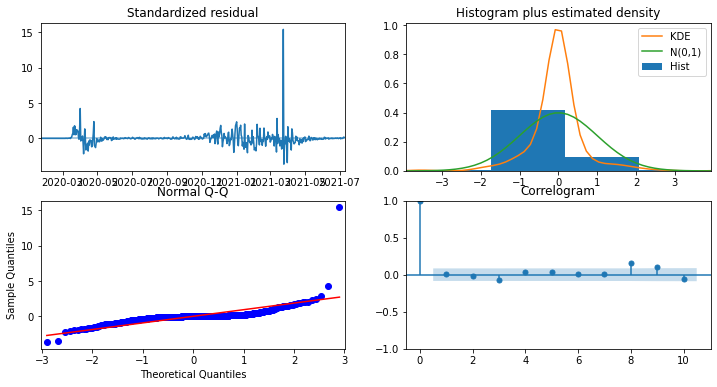

In [37]:
model = tsa.SARIMAX(train,order=auto_model.order, 
                seasonal_order =auto_model.seasonal_order,
                enforce_invertibility=False,freq='D').fit()
display(model.summary())
model.plot_diagnostics();

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           # Cases   No. Observations:                  537
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4659.253
Date:                           Wed, 11 Aug 2021   AIC                           9328.505
Time:                                   19:10:22   BIC                           9349.926
Sample:                               01-22-2020   HQIC                          9336.886
                                    - 07-11-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1552      0.048      3.235      0.001       0.061       0.249
ma.L1         -0.7292      0.049    -15.010      0.000      -0.824      -0.634
ar.S.L7        0.6426      0.104      6.171      0.000       0.439       0.847
ma.S.L7       -0.4117      0.108     -3.829      0.000      -0.622      -0.201
sigma2      2.353e+06   3.84e+04     61.232      0.000    2.28e+06    2.43e+06
===================================================================================
Ljung-Box (Q):                       69.01   Jarque-Bera (JB):            432422.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.19   Skew:                             8.43
Prob(H) (two-sided):                  0.00   Kurtosis:                       141.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

KeyError: 'Lower CI'

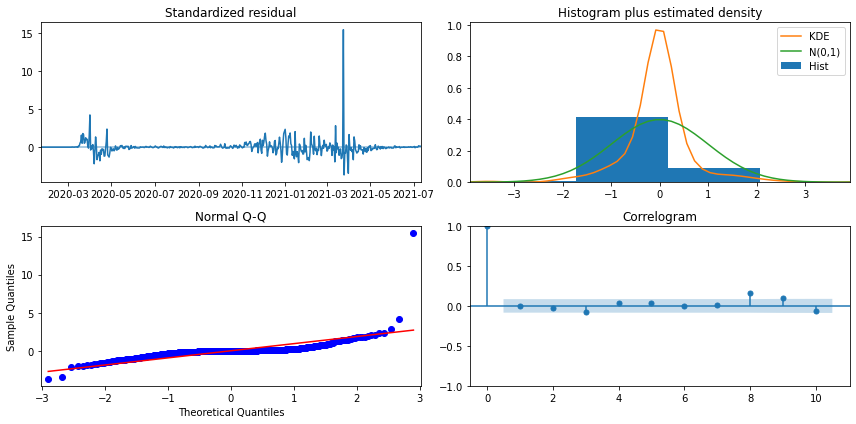

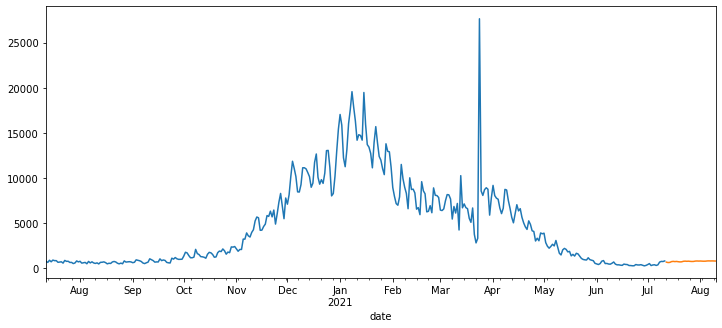

In [38]:
# fn.plot_forecast(model,)
evaluate_model(model,train,test,)

In [ ]:
## Next: if happy, train on entire ts

In [ ]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                seasonal_order =auto_model.seasonal_order,
                enforce_invertibility=False,freq='D').fit()
display(model.summary())
model.plot_diagnostics();

In [ ]:
plot_forecast(model, ts,last_n_lags=500)

## Old Data

In [ ]:
# covid = fn.CovidTrackingProject(verbose=True)
# covid

In [ ]:
# covid.df_states

## Updating Workflow Due to CovidTracking Project API shutting down

- Reverting to using Kaggle dataset. 


# UPDATING 

In [ ]:
cols_to_grab = ['# Cases','# Deaths','inpatient_beds_utilization','adult_icu_bed_utilization']
df_state = STATES['MD'][cols_to_grab].copy()
df_state

In [ ]:


# ## Get df for curr state and resample, keeping the last point for each day
# state_df = df.loc[df['state']==state]
# state_df = state_df.resample('D').last()

# ## save each col into its own dict key
# state_ts_dict = {}
# for col in cols_to_grab:
#     curr_ts = state_df[col].rename(f"{state}-{col}")
#     state_ts_dict[col] = curr_ts
# state_ts_dict

In [ ]:
# cols_to_grab = ['Confirmed','Deaths','Recovered']
# state_data = {}
# for state in state_list:

#     ## Get df for curr state and resample, keeping the last point for each day
#     state_df = df.loc[df['state']==state]
#     state_df = state_df.resample('D').last()

#     ## save each col into its own dict key
#     state_ts_dict = {}
#     for col in cols_to_grab:
#         curr_ts = state_df[col].rename(f"{state}-{col}")
#         state_ts_dict[col] = curr_ts
#     state_data[state] = pd.DataFrame(state_ts_dict)

In [ ]:
# ## pull out md confirmed
# ts = state_data['MD']#['Confirmed']
# ts

# TEST MODELING

In [ ]:
df_state.columns

In [ ]:
ts = df_state['# Cases']
ts.plot()

In [ ]:
ts2 = df_state['adult_icu_bed_utilization']
ts2.plot()

In [ ]:
ts3 = df_state['# Deaths']
ts3.plot()

In [ ]:
##Getting forecast
forecast = model.get_forecast(steps=14)

forecast_df = forecast.conf_int()
forecast_df['Forecast'] = forecast.predicted_mean
forecast_df.columns = ['lower','upper','forecast']
forecast_df

In [ ]:
last_n_days = 60
fig,ax = plt.subplots(figsize=(12,5))
ts.iloc[-last_n_days:].plot(label='True Data')
forecast_df['forecast'].plot(ax=ax)
ax.fill_between(forecast_df.index,
                forecast_df['lower'], forecast_df['upper'],alpha=0.6)
ax.legend()
ax.set(title='Forecasted Hospitalizations (Current) for Maryland')
# ax.plot()